In [1]:
import sys
sys.path.append("/home/diego/python/convolution-kernels/")
sys.path.append("/home/diego/python/stochastic-processes/")
sys.path.append("/home/diego/python/utils/")

import matplotlib.pyplot as plt
import numpy as np

from kernel.fun import KernelFun
from processes.renewal_process import RenewalProcess
# from processes.gaussian_process import GaussianProcess
from processes.dichotomized_gaussian import DichotomizedGaussian
from signals import raw_autocorrelation

%load_ext autoreload
%autoreload 2

In [2]:
A * B, (lam * 1)**2

NameError: name 'A' is not defined

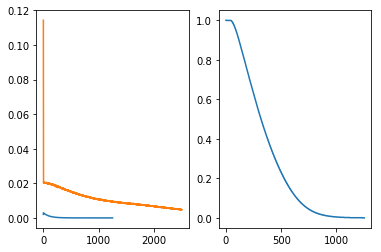

In [20]:
dt = 0.5
t = np.arange(0, 2000, dt)

# lam = 1e-3
# t_autocorr = np.arange(0, 200, 1)
# raw_autocorr = 1e-4 * np.exp(-t_autocorr / 20) + (lam * dt)**2
# raw_autocorr[0] = lam * dt * (1 - lam * dt)

lam, B, A, tau = 0.004124496282873486, 0.0014329870000000001, 0.0029678339000000003, 104.5595075186

# if B < 0:
#     B = (lam * dt)**2 / A
# else:
#     lam = np.sqrt(A * B) / dt

t_autocorr = np.arange(0, tau * 12, dt)
raw_autocorr = A * (B + np.exp(-t_autocorr / tau))
raw_autocorr[0] = lam * dt * (1 - lam * dt)

dg = DichotomizedGaussian(lam=lam, raw_autocorrelation=raw_autocorr)
try:
    dg.set_t(t)
except(np.linalg.LinAlgError):
    print('holi')

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(t_autocorr, raw_autocorr)
ax2.plot(t_autocorr, dg.gp.autocov)

dg.gp.set_cov(t)

dg.gp.cov = dg.gp.cov + 5 * np.eye(len(t))

mask_spikes = dg.sample(t, shape=(100,), cholesky=False)
raw_autocorr_samples = np.mean(raw_autocorrelation(mask_spikes), 1)
ax1.plot(raw_autocorr_samples[:len(t_autocorr)])

In [18]:
tau * 12

1254.7140902232

In [4]:
np.linalg.det(dg.gp.cov)

-0.0

In [8]:
eigvals = np.linalg.eigvals(dg.gp.cov)
# u, svals, v = np.linalg.svd(dg.gp.cov)

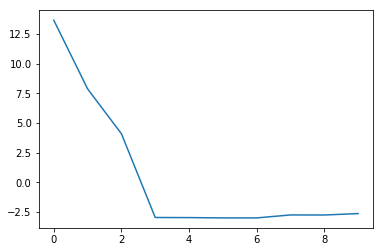

In [16]:
plt.plot(eigvals[10:20])

In [17]:
np.min(eigvals)

-3.0095795983048275

In [7]:
np.min(svals)

3.6892648566968235e-06

In [102]:

cutoff = 1e-1

cov2 = np.exp(-(t_autocorr[:, None] - t_autocorr[None, :])**2 / sigma**2)

u, s, v = np.linalg.svd(cov2)

arg = len(s) - np.searchsorted(s[::-1], cutoff)
print(arg)

26


In [103]:
cov3 = u[:, :arg] @ (s[:arg, None] * v[:arg, :])
np.allclose(cov2, cov3)

False

In [116]:
inv_cov2 = np.linalg.pinv(cov2, rcond=1e-15, hermitian=True)

In [117]:
np.linalg.inv(cov2)

array([[ 4.65373352e+14, -6.81071090e+14,  7.75492935e+14, ...,
        -1.72268224e+16, -1.24492883e+16,  1.00870590e+16],
       [-1.89391179e+15,  2.52585358e+15,  2.46253400e+15, ...,
        -2.56386397e+16, -2.64415071e+16,  3.42160006e+16],
       [ 1.71681736e+15, -2.09151846e+15, -6.27704375e+15, ...,
         8.58100565e+16,  8.20927796e+16, -8.66896851e+16],
       ...,
       [-5.95671377e+13,  9.73752952e+13,  1.56220524e+14, ...,
        -2.00511442e+15, -2.01732549e+15,  2.41246889e+15],
       [ 4.61408780e+13, -2.66386867e+13,  7.22750994e+13, ...,
        -1.39329476e+15, -1.56519071e+15,  1.74170324e+15],
       [ 1.61558688e+12, -2.94111353e+13, -1.11180438e+14, ...,
         1.61121326e+15,  1.74353648e+15, -2.01675017e+15]])

In [118]:
inv_cov2

array([[ 9.99732188e+10, -1.23765586e+10, -7.24444662e+10, ...,
         2.51441528e+10,  6.86688260e+09, -3.69555722e+10],
       [-1.23765586e+10,  1.63022617e+09,  9.12959028e+09, ...,
        -3.03455686e+09, -8.46278316e+08,  4.42622331e+09],
       [-7.24444662e+10,  9.12959028e+09,  5.31405865e+10, ...,
        -2.04878828e+10, -5.56049066e+09,  3.01952589e+10],
       ...,
       [ 2.51441528e+10, -3.03455686e+09, -2.04878828e+10, ...,
         2.75420981e+10,  6.29010530e+09, -4.29159168e+10],
       [ 6.86688260e+09, -8.46278316e+08, -5.56049066e+09, ...,
         6.29010530e+09,  1.53966188e+09, -9.60778321e+09],
       [-3.69555722e+10,  4.42622331e+09,  3.01952589e+10, ...,
        -4.29159168e+10, -9.60778321e+09,  6.72350772e+10]])

In [104]:
np.linalg.det(cov2), np.linalg.det(cov3), np.linalg.cond(cov2), np.linalg.cond(cov3)

(-0.0, 0.0, 2.2524130355684698e+20, 4.210071605616095e+19)

In [105]:
np.linalg.svd(cov3)

(array([[-0.0045679 ,  0.00913211, -0.01368891, ...,  0.02078663,
          0.00612253,  0.00481525],
        [-0.00466347,  0.00931955, -0.01396079, ...,  0.00484928,
         -0.02696101,  0.01278809],
        [-0.00475998,  0.00950869, -0.01423471, ..., -0.00797494,
          0.01114536, -0.0141757 ],
        ...,
        [-0.00475998, -0.00950869, -0.01423471, ...,  0.0133517 ,
         -0.00192618, -0.00284376],
        [-0.00466347, -0.00931955, -0.01396079, ...,  0.00378043,
         -0.01971679,  0.01893643],
        [-0.0045679 , -0.00913211, -0.01368891, ..., -0.00252366,
         -0.00572608,  0.03079692]]),
 array([1.22738146e+02, 1.18823532e+02, 1.12577387e+02, 1.04385835e+02,
        9.47318709e+01, 8.41480281e+01, 7.31679811e+01, 6.22831499e+01,
        5.19090025e+01, 4.23638008e+01, 3.38603924e+01, 2.65097510e+01,
        2.03336042e+01, 1.52827953e+01, 1.12579959e+01, 8.12987812e+00,
        5.75665383e+00, 3.99779422e+00, 2.72356488e+00, 1.82064530e+00,
        1.194

In [81]:
(s[:arg, None] * v[:43, :]).shape

(43, 1000)

In [53]:
np.linalg.det(cov2)

-0.0

In [34]:
from processes.utils import unband_matrix

In [24]:
ch = np.random.randn(2000, 2000)
rand = np.random.randn(2000, 20, 20)
aux1 = ch @ rand[:, :, 0]
aux2 = np.einsum('st,t...->s...', ch,  rand)

In [25]:
np.allclose(aux1, aux2[:, :, 0])

True

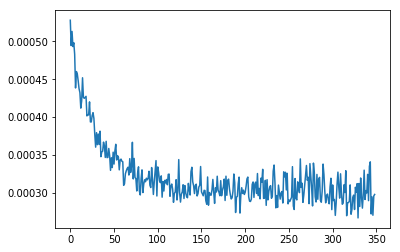

In [27]:
def double_exp(t, A, tr, td, t0):
    return A * tr * td / (td - tr) * (np.exp(-(t - t0) / td) - np.exp(-(t - t0) / tr))

n_trials = 5000
t = np.arange(0, 500, 1)

b, A, tr, td, t0 = -4.5, 0.2, 5, 50, 12
t0 = 2

# eta = KernelFun(double_exp, basis_kwargs=dict(A=np.array([A])), shared_kwargs=dict(tr=tr, td=td, t0=t0), 
#             coefs=np.array([1]), support=[0, tr * td / (td - tr) + td * 7])
eta = KernelFun(lambda t, A, td: A * np.exp(-t / td), basis_kwargs=dict(A=np.array([1])), 
                shared_kwargs=dict(td=td), 
              coefs=np.array([1]), support=[0, td * 7])
rp = RenewalProcess(b, eta)

u, r, mask_spikes = rp.sample(t, shape=(n_trials,))
n_spikes = np.sum(mask_spikes, 0)
raw_autocorr = np.mean(raw_autocorrelation(mask_spikes, biased=False), 1)

lam = np.mean(n_spikes) / (len(t) * 1)

fig, ax1 = plt.subplots()
ax1.plot(raw_autocorr[1:350])

LinAlgError: 3-th leading minor not positive definite

In [33]:
from scipy.special import erfinv
from scipy.stats import multivariate_normal
from processes.gaussian_process import GaussianProcess

from sptr.sptr import SpikeTrain

cov0 = 1e0
p = np.mean(n_spikes) / len(t)
mu = np.sqrt(2 * cov0) * erfinv(2 * p - 1)
drho = 1e-3
rho_gauss = np.arange(-1 + drho, 1, drho)

maxpts = 1e6 * 2

rho_dg = []
for _rho_gauss in rho_gauss:
    cov_gauss = np.array([[cov0, cov0 * _rho_gauss], [cov0 * _rho_gauss, cov0]])
    rho_dg.append(1 + multivariate_normal.cdf([0, 0], mean=np.ones(2) * mu, cov=cov_gauss, maxpts=maxpts) - \
                  2 * multivariate_normal.cdf([0], mean=np.ones(1) * mu, cov=np.array([cov0]), maxpts=maxpts))
rho_dg = np.array(rho_dg)

error_rho = np.abs(raw_autocor[1:250, None] - rho_dg[None, :])
argmin = np.argmin(error_rho, 1)
autocov = cov0 * rho_gauss[argmin]
raw_autocorr_dg = rho_dg[argmin]
error_rho = np.abs(raw_autocor[1:250] - raw_autocorr_dg)
if np.all(error_rho / np.abs(raw_autocor[1:250]) < 1e-1):
    print('small error')
autocov[0] = cov0

dg = DichotomizedGaussian(lam=p / dt, raw_autocorrelation=raw_autocorr)
dg.set_t(t)

small error


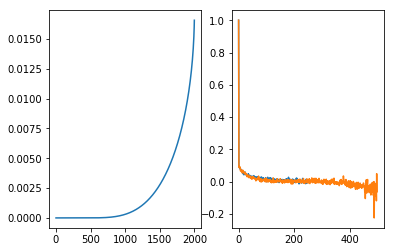

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(rho_dg)

plt.plot(autocov)
plt.plot(dg.gp.autocov)
# plt.plot(error_rho)
# plt.plot(raw_autocor[1:250])
# plt.plot(raw_autocorr_dg)

-2.1064535141647944 0.999714163255708 -2.110510589692119 1.0
8.7036 8.7358


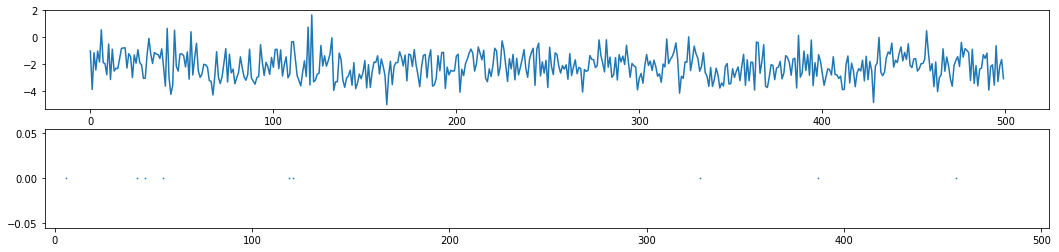

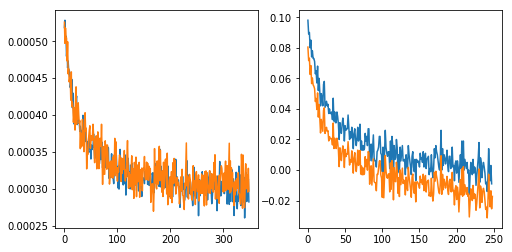

In [20]:
# autocov = 4e0 * np.exp(-np.arange(0, len(autocov), 1) / 20)
gp = GaussianProcess(mu=mu, autocov=autocov)
gp.set_t(t)

u = gp.sample(shape=(5000,))
x = u > 0
gp_autocorr = np.mean(raw_autocorrelation(u, biased=False), 1) - mu**2
raw_autocor2 = np.mean(raw_autocorrelation(x, biased=False), 1) 

print(np.mean(u), np.mean((u - mu)**2), mu, cov0)
print(np.mean(np.sum(mask_spikes, 0)),  np.mean(np.sum(x, 0)))

fig, (ax1, ax2) = plt.subplots(figsize=(18, 4), nrows=2)
ax1.plot(u[:, 0])
SpikeTrain(t, x[:, :1]).plot(ax=ax2, ms=0.7)

fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
ax1.plot(raw_autocor[1:350])
ax1.plot(raw_autocor2[1:350])
# ax1.set_ylim(-1e-5, 4e-4)
# ax1.set_ylim(3e-4, 1e-3)
ax2.plot(autocov[1:250])
ax2.plot(gp_autocorr[1:250])

In [257]:
raw_autocor[0], raw_autocor2[0]

(0.017821999999999998, 0.0177516)

In [48]:
import numpy as np
from scipy.special import erfinv

# from .utils import get_dt

def get_dt(t):
    arg_dt = 20 if len(t) >= 20 else len(t)
    dt = np.mean(np.diff(t[:arg_dt]))
    return dt

class DichotomizedGaussian:
    """Sample stationary spike trains using the Dichotomized Gaussian (Macke et al 2009).

    Attributes:
        lam (str): Baseline firing rate
        attr2 (:obj:`int`, optional): Description of `attr2`.

    """
    def __init__(self, lam=0, raw_autocorrelation=1, drho=1e-3):
        self.lam = lam
        self.raw_autocorrelation = raw_autocorrelation
        
        self.mu = np.sqrt(2) * erfinv(2 * p - 1)
        
        rho_gauss = np.arange(-1 + drho, 1, drho)

        rho_dg = []
        for _rho_gauss in rho_gauss:
            cov_gauss = np.array([[1, _rho_gauss], [_rho_gauss, 1]])
            rho_dg.append(1 + multivariate_normal.cdf([0, 0], mean=np.ones(2) * mu, cov=cov_gauss) - \
                          2 * multivariate_normal.cdf([0], mean=np.ones(1) * mu, cov=np.array([1])))
        rho_dg = np.array(rho_dg)
        
        self.autocov = rho_gauss[np.argmin((raw_autocorrelation - rho_dg[None, :])**2, 1)]
        self.autocov[0] = 1
        
        self.gp = GaussianProcess(mu=self.mu, autocov=self.autocov)

    def set_t(t)
#         self.t = t
        self.gp.set_t(t, inv_cov=False, cholesky=True)
        return self
    
    def sample(self, t=None, shape=(1,), seed=None):
        gp_samples = self.gp.sample(shape=shape, seed=seed)
        mask_spikes = gp_samples > 0
        return mask_spikes
    
    def sample2(self, t, shape=(1,), seed=None):
        """Sample spike trains.

        Args:
            t: 1d-array of time points
            shape: Output is a mask x with x.shape = (len(t),) + shape
            seed: sets numpy seed

        Returns:
            Boolean mask of spikes

        """
        np.random.seed(seed)
        
        dt = get_dt(t)
        
        p = self.lam * dt
        mu = np.sqrt(2) * erfinv(2 * p - 1)
        print(p, mu)
#         var = p * (1 - p)
        var = 1
        
        gaussian_samples = np.random.multivariate_normal(np.ones(len(t)) * mu, np.eye(len(t)) * var, size=shape).T
        print(gaussian_samples[:, 0])
        
        mask_spikes = gaussian_samples > 0
            
        return mask_spikes

In [58]:
dg = DichotomizedGaussian(lam=10)
t = np.arange(0, 2, 1e-3)

mask_spikes = dg.sample(t, shape=(100,))

0.01 -2.3263478740408408
[-2.30744134 -0.67529888 -0.38457111 ... -2.64873573 -1.94806413
 -3.10625501]


In [59]:
np.mean(np.sum(mask_spikes, 0))

19.96

In [19]:
p = 0.4
1 / 2 * (1 + erf(p / np.sqrt(2))), 1 / 2 * (1 + erf(-p / np.sqrt(2))), 1 - 1 / 2 * (1 + erf(p / np.sqrt(2)))

(0.6554217416103242, 0.3445782583896758, 0.3445782583896758)